In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

from analytic_wfm.peakdetect import *

%run "Fonctions.ipynb"

In [2]:
final_df = pd.DataFrame()
files = find_all_extension('../Millau/Resultats/', '.txt')
for elt in files:
    final_df = pd.concat([final_df, recover_sig(elt, ['A07'])], axis=1)

In [3]:
test = []
for elt in final_df.columns:
    if 'time' in elt:
        test.append(elt)
        
final_df[test].isnull().sum()[final_df[test].isnull().sum() == 0].index[0]

'time_20170620143533742'

In [ ]:
2017-06-20-00-03-34-150
2017-06-20-00-03-41-144
2017-06-20-00-05-50-623
2017-06-20-00-05-57-142
2017-06-20-00-08-22-224
2017-06-20-00-33-07-871
2017-06-20-00-38-57-400
2017-06-20-00-39-22-968
2017-06-20-00-41-37-410
2017-06-20-00-45-20-611
2017-06-20-00-52-24-732
2017-06-20-00-54-50-955
2017-06-20-00-56-40-892
2017-06-20-00-57-12-093
2017-06-20-00-59-34-488

In [311]:
# Récupération des signaux
siwim_sig = list_multiple_var('A0', var_to=9) + list_multiple_var('A', 10, 21)
signaux = recover_sig('../Millau/Resultats\\2017-06-20-hh-mm-ss\\2017-06-20-00-mm-ss\\2017-06-20-00-03-41-144.txt', siwim_sig)

# Somme des signaux
signaux = somme_signaux(signaux)

# Supperposition des signaux
signaux = supperposition_signaux(signaux, 10)

# Création de la zone à supprimer
fourchette = signaux.iloc[:int((41/100)*len(signaux)),:].iloc[:,1].std()*3

# Calcul et nettoyage des pics
pics = calcul_pics(signaux, 40, 0.7, fourchette)[0]

In [400]:
def close_point(pic_point, signal):
    diff_time = abs(pic_point[0] - signal.iloc[:,0])
    diff_ampl = abs(pic_point[1] - signal.iloc[:,1])
        
    sum_diff = diff_ampl + diff_time
    id_min = (sum_diff).idxmin()
    
    return signal.loc[id_min,:]

In [246]:
%run "Signal.ipynb"

In [247]:
# Récupération des signaux
siwim_sig = list_multiple_var('A0', var_to=9) + list_multiple_var('A', 10, 21)
signaux = recover_sig('../Millau/Resultats\\2017-06-20-hh-mm-ss\\2017-06-20-00-mm-ss\\2017-06-20-00-41-37-410.txt', siwim_sig)

# Somme des signaux
signaux = somme_signaux(signaux)

# Supperposition des signaux
signaux = supperposition_signaux(signaux, 10)
signaux.columns = ['time', 'amplitude']
sig = Signal('signal1', signaux)

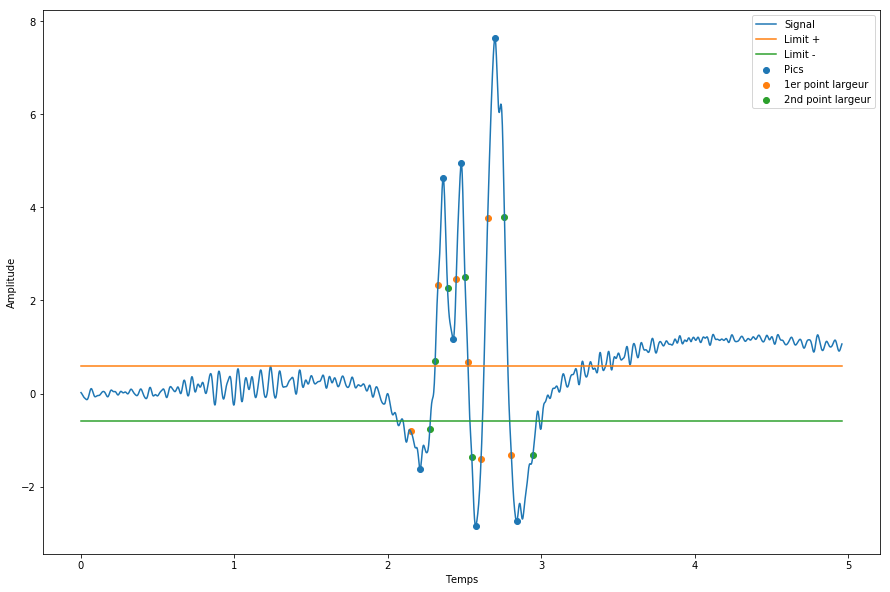

In [248]:
sig.show()

In [576]:
sig.peaks[0].calcultate__half_max()

,time,amplitude
0,0.851562,0.271736


In [583]:
sig.peaks_list('max')

,time,amplitude,sample_number,fwhm,kind
0,0.851562,0.543472,436,0.0,max
1,2.447270,5.301741,1253,0.0,max
2,2.888670,4.692226,1479,0.0,max


In [578]:
middle = sig.calcultate__half_max()
middle

,time,amplitude
0,0.851562,0.271736
1,2.447270,2.650871
2,2.888670,2.346113


In [579]:
points = sig.find_close_point(middle)
points

,sample_number,time,amplitude
0,441,0.861328,0.300195
1,1267,2.474610,2.691486
2,1510,2.949220,2.347920


In [580]:
sig.find_symetric_point(points)

,sample_number,time,amplitude
0,432,0.84375,0.327894
1,1228,2.39844,2.728519
2,1446,2.82422,2.434413


In [602]:
sig.affiche()

AttributeError: 'Signal' object has no attribute 'affiche'

In [605]:
points = find_close_point(signaux, middle)

In [613]:
test = find_symetric_point(signaux, points, pic)

In [401]:
def next_close_point(first_point, signal, max_peak):
    if first_point[0] < max_peak[0]:
        signal_cut = signal[signal.iloc[:,0] > max_peak[0]]
    else:
        signal_cut = signal[signal.iloc[:,0] < max_peak[0]]
    
    return close_point(first_point, signal_cut)

In [402]:
def calcultate_middle(signal, pics):
    max_peaks = min_max_separation(signal, pics)[1]
    
    middle_position = max_peaks.iloc[:,0]
    middle_amplitude = max_peaks.iloc[:,1] - max_peaks.iloc[:,1]/2

    return pd.concat([middle_position, middle_amplitude], axis=1)

In [410]:
def calculate_fwhm(signal, pics):
    first_points = pd.DataFrame()
    second_points = pd.DataFrame()
    
    middle = calcultate_middle(signal, pics)
    max_peaks = min_max_separation(signal, pics)[1]
    
    for row_max, row_middle in zip(max_peaks.iterrows(), middle.iterrows()):
        point = close_point(row_middle[1], signaux)
        second_points = pd.concat([second_points, pd.DataFrame(next_close_point(point, signaux, row_max[1])).T])
        first_points = pd.concat([first_points, pd.DataFrame(point).T])
        
    largeur = pd.DataFrame(np.transpose(np.abs(np.array(second_points.iloc[:,0]) - np.array(first_points.iloc[:,0]))), columns=["Largeur mi-hauteur"])
    
    return (first_points, second_points, largeur)

In [411]:
fwhm = calculate_fwhm(signaux, pics)

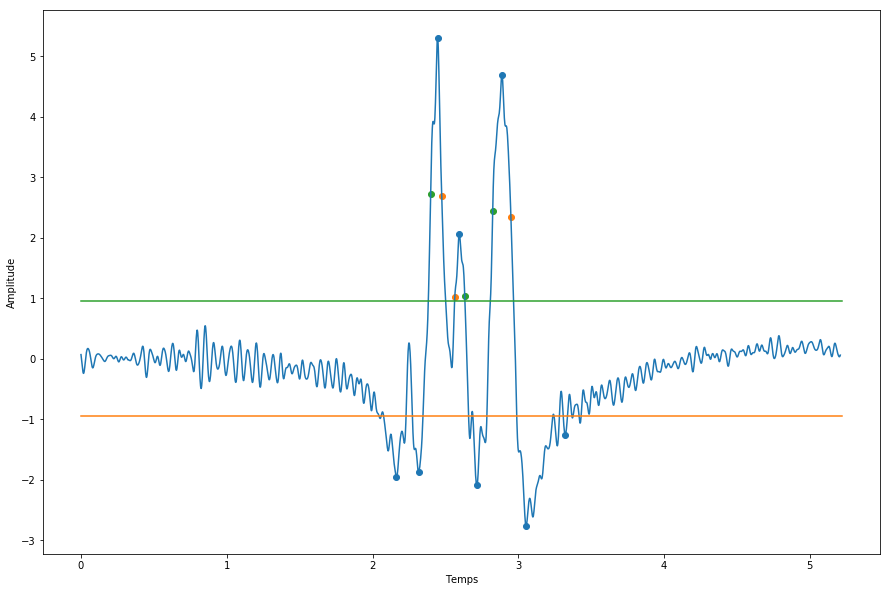

In [614]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(signaux.iloc[:,0], signaux.iloc[:, 1])

# Detections des maximas et minimas
plt.scatter(pics[0], pics[1])
plt.scatter(points.iloc[:,1], points.iloc[:,2])
plt.scatter(test.iloc[:,1], test.iloc[:,2])
#plt.scatter(fwhm[0].iloc[:,0], fwhm[0].iloc[:,1])
#plt.scatter(fwhm[1].iloc[:,0], fwhm[1].iloc[:,1])

plt.plot([0, 5.22], [-fourchette, -fourchette])
plt.plot([0, 5.22], [fourchette, fourchette])

#plt.legend(['A07', 'A09','A12'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

#### Selection meilleur signal

In [301]:
signaux = supperposition_signaux(test)
pics = calcul_pics(signaux, 6, 0.05, 0.15)
best = best_courbe(signaux, pics)

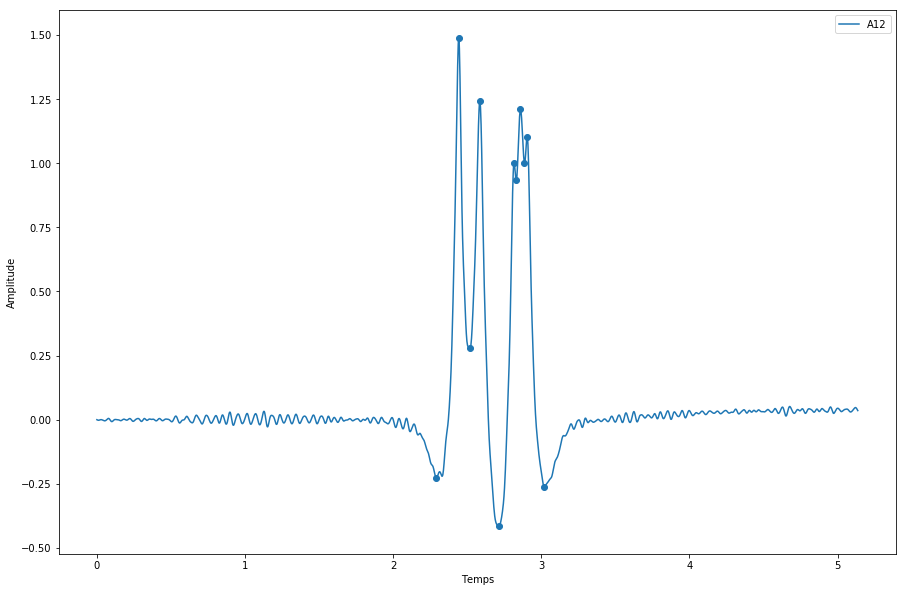

In [302]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(best[0].iloc[:, 0], best[0].iloc[:, 1])

# Detections des maximas et minimas
plt.scatter(best[1].iloc[:, 0], best[1].iloc[:, 1])

plt.legend([best[0].iloc[:,1].name])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

In [348]:
var_name = ['pos_min_', 'min_', 'pos_max_', 'max_']
var_list = []

for elt in var_name:
    if elt == var_name[0] or elt == var_name[1]:
        var_list.append(list_multiple_var(elt, 1, len(min_sig)))
    else:
        var_list.append(list_multiple_var(elt, 1, len(max_sig)))

In [361]:
pos_min = min_sig[[0]].T.reset_index(drop=True)
min_ampl = min_sig[[1]].T.reset_index(drop=True)
pos_max = max_sig[[0]].T.reset_index(drop=True)
max_ampl = max_sig[[1]].T.reset_index(drop=True)

pos_min.columns = var_list[0]
min_ampl.columns = var_list[1]
pos_max.columns = var_list[2]
max_ampl.columns = var_list[3]

In [371]:
pd.concat([,pos_min, min_ampl, pos_max, max_ampl], axis=1)

,pos_min_1,pos_min_2,pos_min_3,pos_min_4,pos_min_5,pos_min_6,min_1,min_2,min_3,min_4,...,pos_max_1,pos_max_2,pos_max_3,pos_max_4,pos_max_5,max_1,max_2,max_3,max_4,max_5
0,2.29102,2.51758,2.71289,2.83203,2.88672,3.02148,-0.22869,0.27787,-0.41501,0.9331,...,2.44336,2.58594,2.81641,2.85938,2.9043,1.48871,1.24161,1.00157,1.20993,1.10396


#### Somme signaux

In [285]:
test3['time'] = test.iloc[:,0]
test3['sig'] = test.iloc[:,1] + test.iloc[:,2] + test.iloc[:,3]

In [286]:
points = peakdetect(test3.iloc[:, 1],test3.iloc[:, 0], lookahead=5, delta=0.04)

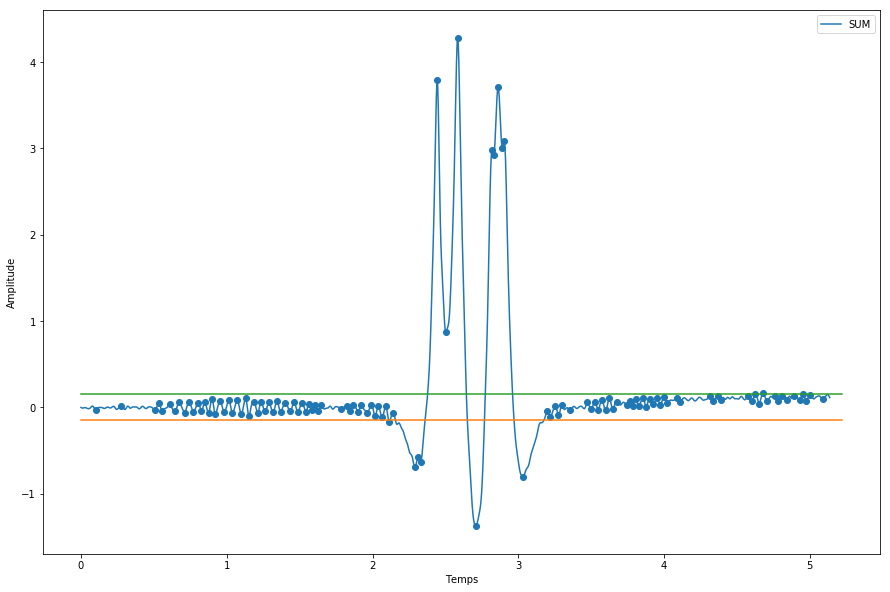

In [287]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(test3.iloc[:,0], test3.iloc[:, 1])

fourchette = 0.15
plt.plot([0, 5.22], [-fourchette, -fourchette])
plt.plot([0, 5.22], [fourchette, fourchette])

# Detections des maximas et minimas
plt.scatter(np.array(points[0] + points[1]).T[0], np.array(points[0] + points[1]).T[1])

plt.legend(['SUM'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()